In [1]:
import csv
import pandas

In [2]:
data = pandas.read_csv("data/qsar-biodeg.csv")
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,2
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,2
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,2
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,2
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,5.431,2.8955,0,0,0,2,0,32.1,4,1,...,0,6,1,3.573,2.242,1,8.088,0,0,1
1051,5.287,3.3732,0,0,9,0,0,35.3,0,9,...,0,3,0,3.787,3.083,3,9.278,0,0,1
1052,4.869,1.7670,0,1,9,0,5,44.4,0,4,...,4,13,0,3.848,2.576,5,9.537,1,0,1
1053,5.158,1.6914,2,0,36,0,9,56.1,0,0,...,1,16,0,5.808,2.055,8,11.055,0,1,1


In [3]:
data.hist('Class')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f673c89f160>]],
      dtype=object)

In [21]:
import numpy as np

features = data.drop("Class", 1).to_numpy().astype(np.float32)
labels = (data["Class"].to_numpy() - 1).astype(np.float32)
num_features = features.shape[1]
num_classes = 2

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [125]:
import sklearn.datasets
import sklearn.pipeline
import sklearn.preprocessing
import skorch

import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModule(nn.Module):
    def __init__(self, num_units=40):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(num_features, num_units)
        self.dropout = nn.Dropout(0.5)
        #self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(num_units, 1)

    def forward(self, X, **kwargs):
        X = F.relu(self.dense0(X))
        # X = self.dropout(X)
        #X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4346       0.8626        0.2989  0.0798
      2        0.3407       0.8957        0.2842  0.0740
      3        0.3116       0.9005        0.2710  0.0715
      4        0.3068       0.8815        0.2821  0.0693
      5        0.3029       0.8483        0.2800  0.0709
      6        0.2877       0.8957        0.2724  0.0718
      7        0.2822       0.8436        0.3295  0.0700
      8        0.2797       0.8863        0.2778  0.0686
      9        0.2698       0.8910        0.2737  0.0680
     10        0.2813       0.8957        0.2567  0.0796
     11        0.2704       0.9005        0.2417  0.0828
     12        0.2694       0.8626        0.2867  0.0827
     13        0.2655       0.9005        0.2731  0.0898
     14        0.2737       0.8863        0.2878  0.0690
     15        0.2654       0.8910        0.2583  0.0668
     16        0.2613       0.9

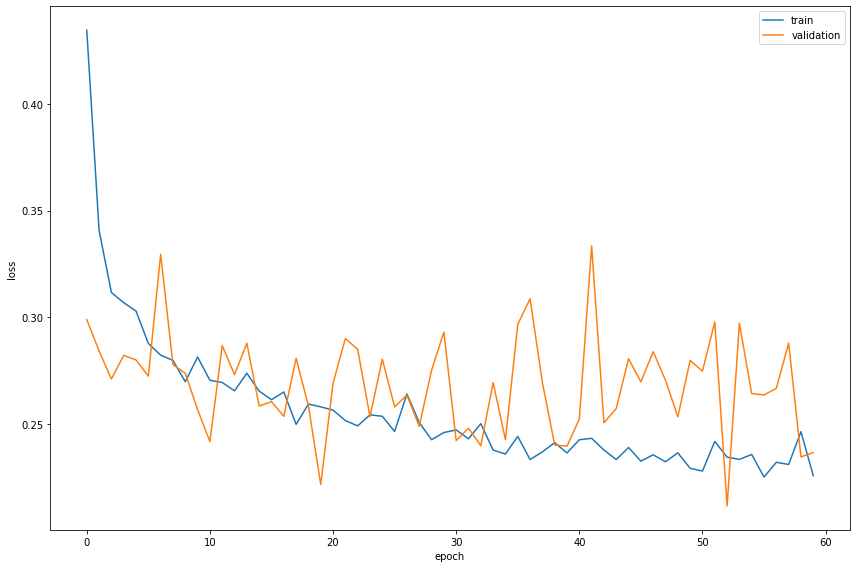

In [130]:
import matplotlib.pyplot as plt
from skorch.classifier import NeuralNetBinaryClassifier

# Learn single model
net = NeuralNetBinaryClassifier(
    MyModule,
    max_epochs=60,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay = 0.0045,
    # Shuffle training data on each epoch
    batch_size=16,
    iterator_train__shuffle=True,
)

pipe = sklearn.pipeline.Pipeline([
    ('scale', sklearn.preprocessing.StandardScaler()),
    ('net', net),
])

pipe.fit(features, labels)

history = net.history
x = list(range(len(history[:, 'valid_loss'])))

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, history[:, 'train_loss'], label='train')
ax.plot(x, history[:, 'valid_loss'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

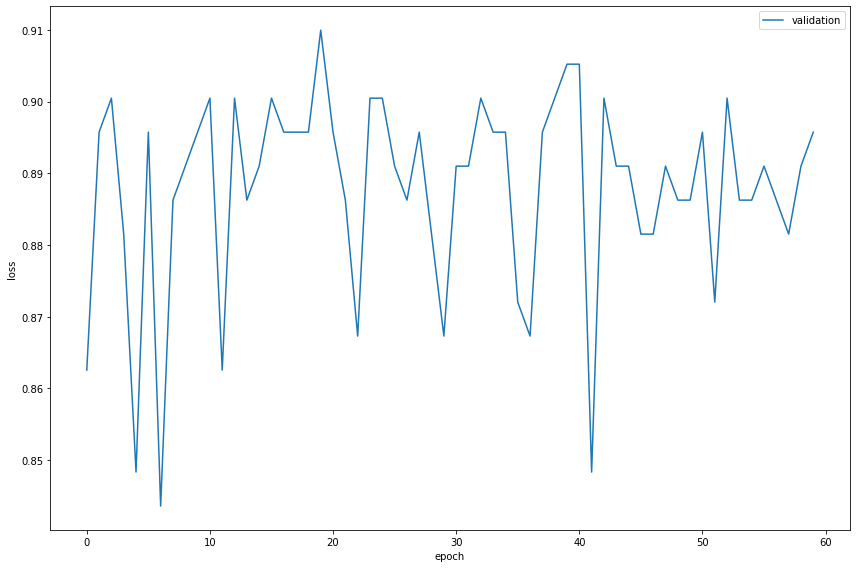

In [132]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, history[:, 'valid_acc'], label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
fig.tight_layout()

In [134]:
# Cross-validation
import sklearn.model_selection
from skorch.classifier import NeuralNetBinaryClassifier

# Learn single model
net = NeuralNetBinaryClassifier(
    MyModule,
    max_epochs=120,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay = 0.0045,
    # Shuffle triterator_train__shuffleaining data on each epoch
    batch_size=16,
    iterator_train__shuffle=True,
)

pipe = sklearn.pipeline.Pipeline([
    ('scale', sklearn.preprocessing.StandardScaler()),
    ('net', net),
])

cv_results = sklearn.model_selection.cross_validate(
    pipe, features, labels, cv=10, return_train_score=False, verbose=True, n_jobs=6)
print(cv_results['test_score'])
print(np.mean(cv_results['test_score']))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[0.87735849 0.89622642 0.85849057 0.9245283  0.87735849 0.8952381
 0.83809524 0.82857143 0.9047619  0.87619048]
0.8776819407008087


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   36.6s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   36.6s finished


In [135]:
# Cross-validation
import sklearn.model_selection
from skorch.classifier import NeuralNetBinaryClassifier

# Learn single model
net = NeuralNetBinaryClassifier(
    lambda: nn.Linear(num_features, 1),
    max_epochs=120,
    optimizer=torch.optim.Adam,
    # Shuffle triterator_train__shuffleaining data on each epoch
    batch_size=16,
    iterator_train__shuffle=True,
)

pipe = sklearn.pipeline.Pipeline([
    ('scale', sklearn.preprocessing.StandardScaler()),
    ('net', net),
])

cv_results = sklearn.model_selection.cross_validate(
    pipe, features, labels, cv=10, return_train_score=False, verbose=True, n_jobs=6)
print(cv_results['test_score'])
print(np.mean(cv_results['test_score']))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[0.85849057 0.8490566  0.76415094 0.9245283  0.83962264 0.83809524
 0.83809524 0.84761905 0.87619048 0.87619048]
0.8512039532794251


[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:   28.4s finished
